# Install and Import required libraries

In [1]:
!pip install pytorch-transformers --quiet

     |████████████████████████████████| 184kB 2.7MB/s 
     |████████████████████████████████| 870kB 8.3MB/s 
     |████████████████████████████████| 1.0MB 16.5MB/s 


In [0]:
from __future__ import absolute_import, division, print_function

import argparse
import csv
import logging
import os
import random
import sys
import json

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from tqdm import tqdm_notebook, tnrange

from torch.nn import CrossEntropyLoss, MSELoss, BCEWithLogitsLoss, L1Loss, Sigmoid
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import pearsonr
import seaborn as sns
import re

import pandas as pd

import torch
from pytorch_transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig, XLNetPreTrainedModel, XLNetModel, AdamW, WarmupLinearSchedule

logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt
%matplotlib inline

# Mount Google drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
sharedGFolderPath = "/content/gdrive/My Drive/TUM/Guided Research/"

# Utility functions, mainly for Data Creation and Loading and Result Visualization

### Data Creation and Loading

In [0]:
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""XLNet finetuning runner."""

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_val_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the validation set."""
        raise NotImplementedError()

    def get_test_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()
        
    @classmethod
    def _read_csv_pickle(cls, input_path, input_file, quotechar=None):
        df = pd.read_pickle(input_path + input_file)
        sentences = df['Sentence'].tolist()
        triplets = df['Triplet'].tolist()
        centities = df['Coarse_Entity'].tolist()
        fentities = df['Fine_Entity'].tolist()
        return [sentences,triplets,centities,fentities]
    
    @classmethod
    def _read_csv(cls, input_path, input_file, classification, sep=',', regressionCol = 'Coarse_Attribute_PU_S'):
        df = pd.read_csv(input_path + input_file, sep=sep)
        sentences = df['Sentence'].tolist()
        if classification:
            triplets = df['Triplet'].tolist()
            centities = df['Coarse_Entity'].tolist()
            fentities = df['Fine_Entity'].tolist()
            cattributes = df['Coarse_Attribute'].tolist()
            entities_sentiments = (df['Coarse_Entity']+'-'+df['Sentiment']).tolist()
            return [sentences,triplets,centities,fentities,cattributes,entities_sentiments]
        else:
            cattributes_PU = df[regressionCol].tolist()
            return [sentences, cattributes_PU]

class Sst2Processor(DataProcessor):
    """Processor for the SST-2 data set (GLUE version)."""
    def __init__(self, classification):
        self.fileName = "dataframePerceptionUncertainty_SingleLabel.csv"
        self.classification = classification

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_csv(os.path.join(data_dir, "train/"), self.fileName, self.classification), "train")
        
    def get_val_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_csv(os.path.join(data_dir, "validation/"), self.fileName, self.classification), "val")

    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_csv(os.path.join(data_dir, "test/"), self.fileName, self.classification), "test")

    def get_extra_test_examples(self, data_dir, input_file):
        """See base class."""
        return self._create_examples(self._read_csv(os.path.join(data_dir, "test/"), input_file, self.classification, sep='|', regressionCol='Coarse_Attribute_PU'), "extra_test")

    def get_labels(self):
        """See base class."""
        entities_fine = ['organic general', 'organic products', 'organic farmers', 'organic companies', 'conventional general', 'conventional products', 
                         'conventional farming', 'conventional companies', 'GMOs genetic engineering general']
        
        entities = ['organic', 'conventional', 'GMO']
        attributes = ['general', 'price', 'experienced quality', 'safety and healthiness', 'trustworthy sources', 'environment']
        sentiments = ['0','p','n']
        
        ABSA = []
        entities_sentiments = []
        for entity in entities:
            for sentiment in sentiments:
                entities_sentiments.append(entity+'-'+sentiment)
                for attribute in attributes:
                    ABSA.append(entity+'-'+attribute+'-'+sentiment)
        return [ABSA, entities, entities_fine, attributes, entities_sentiments]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for i in range(len(lines[0])):
            guid = "%s-%s" % (set_type, i)
            text_a = lines[0][i]
            if self.classification:
                label = (lines[1][i],lines[2][i],lines[3][i],lines[4][i],lines[5][i]) # Send all 5 labels as a tuple, ordered as ABSA, Entity, Entity_Fine, Coarse_Attribute, Entity_Sentiment
            else:
                label = lines[1][i] # Send Regression Target
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples
    
    def get_label_weights(self, data_dir):
        # Load train file
        input_file_path = os.path.join(data_dir, "train/" + self.fileName)
        df = pd.read_csv(input_file_path)
        
        # Assign weights based on value counts
        headWeights = {'ABSA' : 'Triplet', 'Entity' : 'Coarse_Entity', 'Entity_Fine' : 'Fine_Entity'}
        label_list = self.get_labels()
        for i, head in enumerate(headWeights):
            val_counts = np.nan_to_num(df[headWeights[head]].value_counts()[label_list[i]]) + 1
            headWeights[head] = torch.tensor(np.min(val_counts) / val_counts, dtype=torch.float)
            
        return headWeights


def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer, classification,
                                 cls_token_at_end=False,
                                 cls_token='[CLS]',
                                 cls_token_segment_id=1,
                                 sep_token='[SEP]',
                                 pad_on_left=False,
                                 pad_token=0,
                                 pad_token_segment_id=0,
                                 sequence_a_segment_id=0, 
                                 sequence_b_segment_id=1,
                                 mask_padding_with_zero=True):
    """ Loads a data file into a list of `InputBatch`s
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    # For all labels, create reverse mapping to indices
    label_map = []
    for i in range(5):
        label_map.append({label : i for i, label in enumerate(label_list[i])})

    features = []
    for (ex_index, example) in enumerate(examples):
        if ex_index % 1000 == 0:
            logger.info("Writing example %d of %d" % (ex_index, len(examples)))

        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3". " -4" for RoBERTa.
            special_tokens_count = 3
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - special_tokens_count)
        else:
            # Account for [CLS] and [SEP] with "- 2" and with "- 3" for RoBERTa.
            special_tokens_count = 2
            if len(tokens_a) > max_seq_length - special_tokens_count:
                tokens_a = tokens_a[:(max_seq_length - special_tokens_count)]

        tokens = tokens_a + [sep_token]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if tokens_b:
            tokens += tokens_b + [sep_token]
            segment_ids += [sequence_b_segment_id] * (len(tokens_b) + 1)

        if cls_token_at_end:
            tokens = tokens + [cls_token]
            segment_ids = segment_ids + [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
        else:
            input_ids = input_ids + ([pad_token] * padding_length)
            input_mask = input_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
            segment_ids = segment_ids + ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        if classification:
            # Create a label for each example, as a dictionary with head: label as key: val pair
            heads = ['ABSA', 'Entity', 'Entity_Fine', 'Coarse_Attribute', 'Entity_Sentiment']
            label_id = {heads[i]: label_map[i][example.label[i]] for i in range(5)}
        else:
            label_id = example.label

        # Printing 5 samples to check correction
        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info("segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            if classification:
                for i in range(5):
                    logger.info("label-{0}: {1} -> {2}".format(heads[i], label_id[heads[i]], example.label[i]))
            else:
                logger.info("label: {0}".format(label_id))

        features.append(InputFeatures(input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids, label_id=label_id))

    # Return features + dictionary of heads: head_labels as key:val pair, used mainly for visualization later on
    head_classes = None
    if classification:
        head_classes = {heads[i]: label_list[i] for i in range(5)}

    return features, head_classes


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [0]:
def load_and_cache_examples(args, tokenizer, datasetType='train', classification=True):
    processor = Sst2Processor(classification)
    # Load data features from cache or dataset file

    logger.info("Creating features from dataset file at %s", args.data_dir)
    label_list = processor.get_labels()

    examples = processor.get_train_examples(args.data_dir) if datasetType=='train' \
               else processor.get_val_examples(args.data_dir) if datasetType=='val' \
               else processor.get_test_examples(args.data_dir) if datasetType=='test' \
               else processor.get_extra_test_examples(args.data_dir, input_file=datasetType)
    features, head_classes = convert_examples_to_features(examples, label_list, args.max_seq_length, tokenizer, classification,
                                                            cls_token_at_end=True,            # xlnet has a cls token at the end
                                                            cls_token=tokenizer.cls_token,
                                                            cls_token_segment_id=2,
                                                            sep_token=tokenizer.sep_token,
                                                            pad_on_left=True,                 # pad on the left for xlnet
                                                            pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                                            pad_token_segment_id=4,
                                                        )

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    if classification:
        all_label_ids_absa = torch.tensor([f.label_id['ABSA'] for f in features], dtype=torch.long)
        all_label_ids_centity = torch.tensor([f.label_id['Entity'] for f in features], dtype=torch.long)
        all_label_ids_fentity = torch.tensor([f.label_id['Entity_Fine'] for f in features], dtype=torch.long)
        all_label_ids_cattributes = torch.tensor([f.label_id['Coarse_Attribute'] for f in features], dtype=torch.long)
        all_label_ids_entities_sentiments = torch.tensor([f.label_id['Entity_Sentiment'] for f in features], dtype=torch.long)
        dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids_absa, all_label_ids_centity, all_label_ids_fentity, all_label_ids_cattributes, all_label_ids_entities_sentiments)
    else:
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)
        dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    
    if datasetType == 'train':
        return dataset, head_classes
    return dataset


### Result calculation

In [0]:
def simple_accuracy(preds, labels):
    return (preds == labels).mean()


def acc_and_f1(preds, labels, average='binary'):
    acc = simple_accuracy(preds, labels)
    f1 = f1_score(y_true=labels, y_pred=preds, average=average)
    return {
        "acc": acc,
        "f1": f1,
        "acc_and_f1": (acc + f1) / 2,
    }


def compute_metrics(preds, labels):
    assert len(preds) == len(labels)
    return {"acc": acc_and_f1(preds, labels, 'micro')}

### Plotting Graphs for visualizing Experimental results

In [0]:
# Calculate running mean
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


# Plot result of training and evaluation
def plot_train_val_trace(train_trace, validation_trace):
    train_val_ratio = int(len(train_trace)/len(validation_trace))
    train_loss = []
    for i in range(len(validation_trace)):
        train_loss.append(np.mean(train_trace[i*train_val_ratio:(i+1)*train_val_ratio]))
    plt.plot(running_mean(train_loss,15),label='Training Loss')
    plt.plot(running_mean(validation_trace,15),label='Validation Loss')
    plt.legend()
    plt.show()

    
def get_heatmap_classes(head):
    if head == 'Entity':
        return head_classes[head]
    elif head == 'Entity_Fine':
        return ['g', 'p', 'f', 'c', 'cg', 'cp', 'cf', 'cc', 'gg']
    else:
        ABSA = []
        entities = ['o', 'c', 'gmo']
        attributes = ['g', 'p', 'e_q', 's_h', 't_s', 'env']
        sentiments = ['0', 'p', 'n']
        for entity in entities:
            for attribute in attributes:
                for sentiment in sentiments:
                    ABSA.append(entity+'-'+attribute+'-'+sentiment)
        return ABSA

# For plotting Confusion matrices HEATMAP          
def plot_Confusion_matrices(cHead):
    classes = headConfig[cHead]
    confusion_matrix = torch.zeros(classes, classes)
    for t, p in zip(results[cHead]['actual'], results[cHead]['preds']):
        confusion_matrix[t, p] += 1

    cm = confusion_matrix.numpy()
    cm_sum = cm.astype(np.float).sum(axis=1) + 1e-9
    
    not_Absa = True if cHead != 'ABSA' else False
    fig,ax= plt.subplots(figsize=(12,12))
    sns.heatmap(cm / cm_sum.reshape(-1, 1), annot=not_Absa, ax=ax, vmin=0.0, vmax=1.0)

    # labels, title and ticks
    ax.xaxis.set_ticklabels(head_classes[cHead], size=8, rotation=45)
    ax.yaxis.set_ticklabels(head_classes[cHead], size=8, rotation=45)
    ax.set_xlabel('Predicted', size=25)
    ax.set_ylabel('True', size=25)
    ax.set_title('Confusion Matrix', size=25)
    """
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    """
    plt.savefig('crossEntropy_'+cHead+'_cm.pdf')
    fig.show()

### Classification Reports

In [0]:
def save_classification_report(classification_report, title='Classification report '):
    lines = classification_report.split('\n')
    if (len(lines) > 100):
        return;

    plotMat = []
    support = []
    class_names = []
    report_data = []
    for line in lines[2 : (len(lines) - 2)]:
        t = re.split(r'\s{2,}', line.strip())
        if len(t) < 2:
            continue
        
        row = {}
        class_names.append(t[0])
        row['class'] = t[0]
        v = [float(x) for x in t[1: len(t) - 1]]
        if row['class'] != 'accuracy':
            row['precision'] = v[0]
            row['recall'] = v[1]
            row['f1_score'] = v[2]
        else:
            row['f1_score'] = v[0]
        support.append(int(t[-1]))
        row['support'] = int(t[-1])
        
        #print(v)
        plotMat.append(v)
        report_data.append(row)
        
    pd.DataFrame.from_dict(report_data).to_csv(os.path.join(args.output_dir, title+'.csv'), index = False)
    

def get_cr_reports(shouldSave=False):
    for head in headConfig:
        if head == 'ABSA':
            cr = classification_report(results[head]['actual'], results[head]['preds'], labels=np.arange(54), target_names=head_classes[head])
        else:
            cr = classification_report(results[head]['actual'], results[head]['preds'], target_names=head_classes[head])
        
        if shouldSave:
            save_classification_report(cr, title=head+' Report')
        else:
            print(cr)

### Produce predictions

In [0]:
def produce_predictions(results, data_dir):
    df = pd.read_csv(os.path.join(data_dir, "test/dataframePerceptionUncertainty_SingleLabel.csv"))
    for head in headConfig:
        label_map = {i : label for i, label in enumerate(head_classes[head])}
        pred_labels = [label_map[pred_id] for pred_id in results[head]['preds']]
        df[head+'_predicted'] = pred_labels

    df.to_csv(os.path.join(data_dir, "test/dataframePerceptionUncertainty_SingleLabel_predictions.csv"), encoding='utf-8',index=False)

# Training and Evaluating Functions

In [0]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

In [0]:
def train(args, train_dataset, model, tokenizer, eval_dataset, classification=True):
    """ Train the model """
    loss_trace = []
    eval_loss_trace = []  # For evaluation trace during training
    if classification:
        head_loss_trace = {head: [] for head in headConfig}  # for detailed training loss trace for each head

    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)

    t_total = len(train_dataloader) * args.num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args.weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = WarmupLinearSchedule(optimizer, warmup_steps=args.warmup_steps, t_total=t_total)

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss = 0.0
    model.zero_grad()
    
    # Train for args.num_train_epochs Epochs
    train_iterator = tnrange(int(args.num_train_epochs), desc="Epoch")
    set_seed(args)  # Added here for reproductibility (even between python 2 and 3)
    for _ in train_iterator:
        epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
        for step, batch in enumerate(epoch_iterator):
            model.train()
            
            # Get the data and set it up as required by the model
            batch = tuple(t.to(args.device) for t in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2]}
            if classification:
                inputs['labels'] = {'ABSA' : batch[3], 'Entity' : batch[4], 'Entity_Fine' : batch[5], 'Coarse_Attribute' : batch[6], 'Entity_Sentiment' : batch[7]}
            else:
                inputs['labels'] = batch[3]
            
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

            # Add loss to loss traces
            loss_trace.append(loss.item())
            if classification:
                detailed_loss = outputs[1]
                for head in headConfig:
                    head_loss_trace[head].append(detailed_loss[head].item())

            epoch_iterator.set_postfix(loss=loss.item())
            tr_loss += loss.item()
            
            # Take gradient optimizer steps
            optimizer.step()
            scheduler.step()
            model.zero_grad()
            
            global_step += 1

            if args.logging_steps > 0 and global_step % args.logging_steps == 0:
                if args.evaluate_during_training:
                    eval_loss_trace.extend(evaluate(args, model, tokenizer, eval_dataset, prefix=str(global_step), classification=classification)[1])


            if args.save_steps > 0 and global_step % args.save_steps == 0:
                # Save model checkpoint
                logger.info("Saving model checkpoint to %s", args.output_dir)
                torch.save(args, os.path.join(args.output_dir, 'training_args.bin'))
                torch.save(model.state_dict(), os.path.join(args.output_dir, 'checkpoint-{}.pt'.format(global_step)))

    returnData = (global_step, tr_loss / global_step, loss_trace, eval_loss_trace)
    if classification:
        returnData = returnData + (head_loss_trace,)
    return returnData

In [0]:
def evaluate(args, model, tokenizer, eval_dataset, prefix="", classification=True):
    loss_trace = []

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    
    eval_loss = 0.0
    nb_eval_steps = 0
    
    # For keeping track of predictions and actual labels to be returned
    preds = None
    out_label_ids = None
    
    for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
        model.eval()
        
        # Get the data and set it up as required by the model
        batch = tuple(t.to(args.device) for t in batch)
        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2]}
            if classification:
                inputs['labels'] = {'ABSA' : batch[3], 'Entity' : batch[4], 'Entity_Fine' : batch[5], 'Coarse_Attribute' : batch[6], 'Entity_Sentiment' : batch[7]}
            else:
                inputs['labels'] = batch[3]
            
            outputs = model(**inputs)
            loss = outputs[0]

            # Add loss to loss trace
            loss_trace.append(loss.item())
            eval_loss += loss.item()

            if classification:
                logits = outputs[2]
            else:
                logits = outputs[1]
        
        nb_eval_steps += 1
        if preds is None:
            if classification:
                preds = {head: logits[head].detach().cpu().numpy() for head in headConfig}  # For each head, add the logits to preds
                out_label_ids = {head: inputs['labels'][head].detach().cpu().numpy() for head in headConfig}  # For each head, add the actual labels to out_label_ids
            else:
                preds = logits.detach().cpu().numpy()
                out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            if classification:
                preds = {head: np.append(preds[head], logits[head].detach().cpu().numpy(), axis=0) for head in headConfig}  # For each head, add the logits to preds
                out_label_ids = {head: np.append(out_label_ids[head], inputs['labels'][head].detach().cpu().numpy(), axis=0) for head in headConfig}  # For each head, add the actual labels to out_label_ids
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    logger.info("evaluation average loss = %s", eval_loss)
    
    if classification:
        # Calculate predictions from the logits using argmax, and set up a dictionary with predictions and actual labels for each head
        results = {head: {'actual': out_label_ids[head], 'preds': np.argmax(preds[head], axis=1)} for head in headConfig}
    else:
        results = {'actual': out_label_ids, 'preds': preds}

    return eval_loss, loss_trace, results

# Define XLNET Models

## Define XLNET Model for ABSA

In [0]:
class XLNetABSAwithHeads(torch.nn.Module):
    def __init__(self, config, xlnetDim = 768, model_type='xlnet-base-cased', dropout=0.1, loss_weights=None):
        super(XLNetABSAwithHeads, self).__init__()

        self.transformer = XLNetModel.from_pretrained(model_type)
        self.configHead = config
        self.loss_weights = loss_weights
        # self.dropout_layer = torch.nn.Dropout(dropout)
        
        # Build up the heads from the config dictionary
        config_dict = {}
        for head in self.configHead:
            config_dict[head] = torch.nn.Linear(in_features=xlnetDim, out_features=self.configHead[head])

        self.heads = torch.nn.ModuleDict(config_dict)

        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, torch.nn.ModuleDict):
            # Initialize each linear layer
            for layer in module.children():
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if isinstance(layer, torch.nn.Linear) and layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_ids, token_type_ids=None, input_mask=None, attention_mask=None, mems=None, perm_mask=None, target_mapping=None, labels=None, head_mask=None, loss_weights=None):
        # Get the output from XLNET model                                        
        transformer_outputs = self.transformer(input_ids, token_type_ids=token_type_ids,
                                               input_mask=input_mask, attention_mask=attention_mask,
                                               mems=mems, perm_mask=perm_mask, target_mapping=target_mapping,
                                               head_mask=head_mask)
        output = transformer_outputs[0]
        # Pick the last token for classification
        output = output[:, -1]
        # Do dropout
        # output = self.dropout_layer(output)

        # Use last token and pass it seperately through each head, to get head_logits
        head_logits = {}
        for head in self.configHead:
            head_logits[head] = self.heads[head](output)

        # Add head_logits to output tuple
        outputs = (head_logits,) + transformer_outputs[1:]  # Keep mems, hidden states, attentions if there are in it

        # Calculate loss for each head, and send back total loss + detailed loss
        if labels is not None:
            head_loss = {}
            loss_fct = CrossEntropyLoss()
            for head in self.configHead:
                # loss_fct = CrossEntropyLoss(weight=self.loss_weights[head].cuda())
                head_loss[head] = loss_fct(head_logits[head], labels[head])
            outputs = (sum(head_loss.values()), head_loss) + outputs

        return outputs  # return (total loss, detailed loss), logits, mems, (hidden states), (attentions)


## Define XLNET Model for Regression

In [0]:
class XLNetRegression(torch.nn.Module):
    def __init__(self, xlnetDim = 768, model_type='xlnet-base-cased'):
        super(XLNetRegression, self).__init__()

        self.transformer = XLNetModel.from_pretrained(model_type)
        self.fc_layer = torch.nn.Linear(in_features=xlnetDim, out_features=1)
        self.sigmoid = Sigmoid()
        
        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, torch.nn.ModuleDict):
            # Initialize each linear layer
            for layer in module.children():
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if isinstance(layer, torch.nn.Linear) and layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_ids, token_type_ids=None, input_mask=None, attention_mask=None, mems=None, perm_mask=None, target_mapping=None, labels=None, head_mask=None, loss_weights=None):
        # Get the output from XLNET model                                        
        transformer_outputs = self.transformer(input_ids, token_type_ids=token_type_ids,
                                               input_mask=input_mask, attention_mask=attention_mask,
                                               mems=mems, perm_mask=perm_mask, target_mapping=target_mapping,
                                               head_mask=head_mask)
        output = transformer_outputs[0]
        # Pick the last token for classification
        output = output[:, -1]
        # Pass through fc layer
        logits = torch.squeeze(self.sigmoid(self.fc_layer(output)))

        # Add logits to output tuple
        outputs = (logits,) + transformer_outputs[1:]  # Keep mems, hidden states, attentions if there are in it

        # Calculate loss
        if labels is not None:
            loss_fct = L1Loss()
            loss = loss_fct(logits, labels)
            outputs = (loss,) + outputs

        return outputs  # return loss, logits, mems, (hidden states), (attentions)


# Set Config and Logging

In [0]:
def readConfig():
    args = argparse.Namespace()
    args.model_type = 'xlnet-base-cased'
    args.data_dir = sharedGFolderPath+'data/'
    args.output_dir = sharedGFolderPath+'output/Current/'
    args.max_seq_length = 32
    args.train_batch_size = 32
    args.eval_batch_size = 32
    args.learning_rate = 5e-5
    args.num_train_epochs = 20.0
    args.warmup_steps = 0
    args.seed = 42
    args.weight_decay = 0.1
    args.adam_epsilon = 1e-8
    args.max_grad_norm = 1.0
    args.logging_steps = 50
    args.save_steps = 0
    args.evaluate_during_training = True
    
    return args

In [0]:
args = readConfig()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.device = device
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', datefmt = '%m/%d/%Y %H:%M:%S', level = logging.INFO)

In [0]:
classification = False  # TRUE if classification model / data needed, otherwise FALSE
headConfig = {'ABSA' : 54, 'Entity' : 3, 'Entity_Fine' : 9}   # Dict for attrbiute name with number of classes for that attribute, used in Classification
#headConfig = {'ABSA' : 54}
#headConfig = {'ABSA' : 54, 'Entity' : 3, 'Entity_Fine' : 9, 'Coarse_Attribute' : 6, 'Entity_Sentiment' : 9}

# Load the Custom Model and Tokenizer

In [0]:
tokenizer = XLNetTokenizer.from_pretrained(args.model_type)
if classification:
    model = XLNetABSAwithHeads(headConfig, model_type=args.model_type)
else:
    model = XLNetRegression(model_type=args.model_type)

# Load up Training and Evaluation dataset

In [73]:
set_seed(args)

train_dataset, head_classes = load_and_cache_examples(args, tokenizer, datasetType='train', classification=classification)
eval_dataset = load_and_cache_examples(args, tokenizer, datasetType='val', classification=classification)

02/01/2020 01:35:39 - INFO - __main__ -   Creating features from dataset file at /content/gdrive/My Drive/TUM/Guided Research/data/
02/01/2020 01:35:39 - INFO - __main__ -   Writing example 0 of 4218
02/01/2020 01:35:39 - INFO - __main__ -   *** Example ***
02/01/2020 01:35:39 - INFO - __main__ -   guid: train-0
02/01/2020 01:35:39 - INFO - __main__ -   tokens: ▁Cook if i ▁is ▁one ▁of ▁the ▁leading ▁Organic ▁cater ers ▁in ▁Bangalore . <sep> <cls>
02/01/2020 01:35:39 - INFO - __main__ -   input_ids: 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5030 1963 150 27 65 20 18 895 22032 13484 270 25 21548 9 4 3
02/01/2020 01:35:39 - INFO - __main__ -   input_mask: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
02/01/2020 01:35:39 - INFO - __main__ -   segment_ids: 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
02/01/2020 01:35:39 - INFO - __main__ -   label-ABSA: 4 -> organic-trustworthy sources-0
02/01/2020 01:35:39 - INFO - __main__ -   label-Entity: 0 -> organic
02/01/20

# Run training on the Model

In [74]:
model.to(device)

outputs = train(args, train_dataset, model, tokenizer, eval_dataset, classification=classification)
global_step, tr_loss, train_loss_trace, eval_loss_trace = outputs[:4]
if classification:
    train_head_loss_trace = outputs[4]
logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

02/01/2020 01:35:44 - INFO - __main__ -   ***** Running training *****
02/01/2020 01:35:44 - INFO - __main__ -     Num examples = 4218
02/01/2020 01:35:44 - INFO - __main__ -     Num Epochs = 3
02/01/2020 01:35:44 - INFO - __main__ -     Total optimization steps = 396


02/01/2020 01:35:58 - INFO - __main__ -   ***** Running evaluation 50 *****
02/01/2020 01:35:58 - INFO - __main__ -     Num examples = 372
02/01/2020 01:35:58 - INFO - __main__ -     Batch size = 32


02/01/2020 01:35:59 - INFO - __main__ -   evaluation average loss = 4.599934299786885
02/01/2020 01:36:13 - INFO - __main__ -   ***** Running evaluation 100 *****
02/01/2020 01:36:13 - INFO - __main__ -     Num examples = 372
02/01/2020 01:36:13 - INFO - __main__ -     Batch size = 32


02/01/2020 01:36:14 - INFO - __main__ -   evaluation average loss = 4.430887699127197


02/01/2020 01:36:29 - INFO - __main__ -   ***** Running evaluation 150 *****
02/01/2020 01:36:29 - INFO - __main__ -     Num examples = 372
02/01/2020 01:36:29 - INFO - __main__ -     Batch size = 32


02/01/2020 01:36:30 - INFO - __main__ -   evaluation average loss = 4.042849242687225
02/01/2020 01:36:44 - INFO - __main__ -   ***** Running evaluation 200 *****
02/01/2020 01:36:44 - INFO - __main__ -     Num examples = 372
02/01/2020 01:36:44 - INFO - __main__ -     Batch size = 32


02/01/2020 01:36:45 - INFO - __main__ -   evaluation average loss = 3.9395357966423035
02/01/2020 01:37:00 - INFO - __main__ -   ***** Running evaluation 250 *****
02/01/2020 01:37:00 - INFO - __main__ -     Num examples = 372
02/01/2020 01:37:00 - INFO - __main__ -     Batch size = 32


02/01/2020 01:37:01 - INFO - __main__ -   evaluation average loss = 3.7923223773638406


02/01/2020 01:37:15 - INFO - __main__ -   ***** Running evaluation 300 *****
02/01/2020 01:37:15 - INFO - __main__ -     Num examples = 372
02/01/2020 01:37:15 - INFO - __main__ -     Batch size = 32


02/01/2020 01:37:16 - INFO - __main__ -   evaluation average loss = 3.9959566990534463
02/01/2020 01:37:31 - INFO - __main__ -   ***** Running evaluation 350 *****
02/01/2020 01:37:31 - INFO - __main__ -     Num examples = 372
02/01/2020 01:37:31 - INFO - __main__ -     Batch size = 32


02/01/2020 01:37:32 - INFO - __main__ -   evaluation average loss = 3.897198041280111
02/01/2020 01:37:46 - INFO - __main__ -    global_step = 396, average loss = 3.6375539471404723


# Visualize model performance during Training

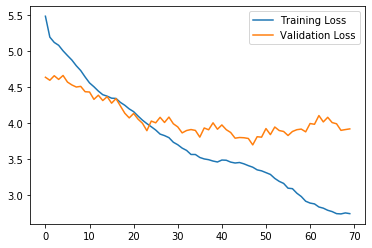

In [75]:
if args.evaluate_during_training:
    plot_train_val_trace(train_loss_trace, eval_loss_trace)

## Only for Classification

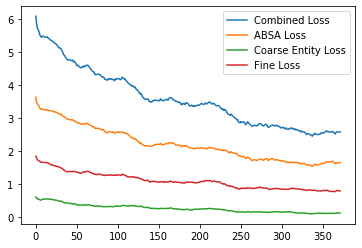

In [76]:
plt.plot(running_mean(train_loss_trace, 25), label='Combined Loss')
plt.plot(running_mean(train_head_loss_trace['ABSA'], 25), label='ABSA Loss')
plt.plot(running_mean(train_head_loss_trace['Entity'], 25), label='Coarse Entity Loss')
plt.plot(running_mean(train_head_loss_trace['Entity_Fine'], 25), label='Fine Loss')
#plt.plot(running_mean(train_head_loss_trace['Coarse_Attribute'], 25), label='Coarse Attribute Loss')
#plt.plot(running_mean(train_head_loss_trace['Entity_Sentiment'], 25), label='Entity_Sentiment Loss')
plt.legend()
plt.show()

# Save the model (If Needed)



In [0]:
logger.info("Saving trained model to %s", args.output_dir)
tokenizer.save_pretrained(args.output_dir)
torch.save(args, os.path.join(args.output_dir, 'training_args.bin'))
torch.save(model.state_dict(), os.path.join(args.output_dir, 'model.pt'))

01/30/2020 08:58:01 - INFO - __main__ -   Saving trained model to /content/gdrive/My Drive/TUM/Guided Research/output/Current/


## Load the Saved Model

In [0]:
tokenizer = XLNetTokenizer.from_pretrained(args.model_type)
if classification:
    model = XLNetABSAwithHeads(headConfig, model_type=args.model_type)
else:
    model = XLNetRegression(model_type=args.model_type)
model.load_state_dict(torch.load(os.path.join(args.output_dir, 'model.pt')))
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Load the Test dataset and Check performance of Trained model on it

In [93]:
# Give File Name for datasetType if evaluation needs to be done on seperate evaluation set, otherwise simply set datasetType='test' for normal testing on test set
test_dataset = load_and_cache_examples(args, tokenizer, datasetType='jointly_annotated_PU_original_NIE.csv', classification=classification)
test_loss, test_loss_trace, results = evaluate(args, model, tokenizer, test_dataset, prefix='Test set', classification=classification)

02/01/2020 01:51:16 - INFO - __main__ -   Creating features from dataset file at /content/gdrive/My Drive/TUM/Guided Research/data/
02/01/2020 01:51:16 - INFO - __main__ -   Writing example 0 of 258
02/01/2020 01:51:16 - INFO - __main__ -   *** Example ***
02/01/2020 01:51:16 - INFO - __main__ -   guid: extra_test-0
02/01/2020 01:51:16 - INFO - __main__ -   tokens: ▁Consider ▁that ▁there ▁are ▁myriad ▁varieties ▁of ▁natural ▁pest ▁control ▁measures ▁used ▁by ▁organic - certified ▁farms ▁including ▁oil - based ▁ s uff oc ants , ▁which ▁ - <sep> <cls>
02/01/2020 01:51:16 - INFO - __main__ -   input_ids: 10840 29 105 41 20746 11102 20 1136 13112 475 1858 179 37 5881 13 25799 9199 208 607 13 716 17 23 7276 3374 4080 19 59 17 13 4 3
02/01/2020 01:51:16 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
02/01/2020 01:51:16 - INFO - __main__ -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
02/01/2020 01:51:16 - INF

02/01/2020 01:51:17 - INFO - __main__ -   evaluation average loss = 0.37304292619228363


# Visualize Trained Model's performance on Test dataset

## Only for Regression

### Code for Pearson correlation calculation

#### With all samples

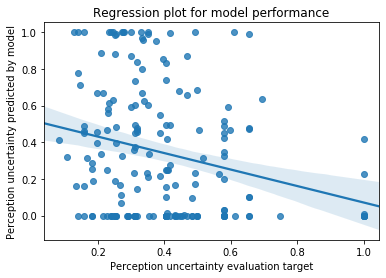

In [100]:
sns.regplot(results['actual'], results['preds'])
plt.xlabel("Perception uncertainty evaluation target")
plt.ylabel("Perception uncertainty predicted by model")
plt.title('Regression plot for model performance')
plt.savefig('regplot_NIE_PC_all.pdf')
plt.show()

In [0]:
corr = pearsonr(results['actual'], results['preds'])
corr

#### With only samples that have Perception Uncertainty > 0

In [94]:
# Count number of samples with 0 Perception Uncertainty
k = 0
total = 0
j = 0
for i in range(len(results['actual'])):
    if results['actual'][i] == 0:
        k+=1
    else:
        j+=1
    total+=1
k, total, j, k/j

(72, 258, 186, 0.3870967741935484)

In [0]:
# Remove 0 Perception Uncertainty samples from evaluation
a = []
for i in range(len(results['actual'])):
    if results['actual'][i] == 0:
        a.append(i)

b = np.delete(results['actual'], a)
c = np.delete(results['preds'], a)

In [0]:
sns.regplot(b, c)
plt.xlabel("Perception uncertainty evaluation target")
plt.ylabel("Perception uncertainty predicted by model")
plt.title('Regression plot for model performance')
plt.savefig('regplot_NIE_PC_small.pdf')
plt.show()

In [102]:
corr = pearsonr(b, c)
corr

(-0.25347919281246134, 0.00048143463894306695)

### Weighted Correlation

In [0]:
def weighted_cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(y, weights=w))) / np.sum(w)

def weighted_corr(x, y, w):
    """Weighted Correlation"""
    return weighted_cov(x, y, w) / np.sqrt(weighted_cov(x, x, w) * weighted_cov(y, y, w))

In [0]:
# Load the test file for Annotation counts, to be used as weights in Weighted Correlation
df_test = pd.read_csv(os.path.join(args.data_dir, "test/jointly_annotated_PU_original_NIE.csv"), sep="|")

In [0]:
weighted_corr(results['actual'], results['preds'], df_test['Annotation_Count'].tolist())

-0.10724199970563689

### Accuracy calculation based on confidence interval

In [0]:
def calc_test_accuracy(actual, preds, conf_interval):
    result = [True if preds[i] >= actual[i] - conf_interval[i] and preds[i] <= actual[i] + conf_interval[i] else False for i in range(len(actual))]
    return np.mean(result)

In [0]:
# Load the test file for Confidence Interval
df_test = pd.read_csv(os.path.join(args.data_dir, "test/jointly_annotated_PU_NIE_3.csv"), sep='|')
conf_interval = df_test['Confidence_Interval'].tolist()

In [0]:
calc_test_accuracy(results['actual'], results['preds'], conf_interval)

## Only for Classification

In [78]:
for head in headConfig:
    print(head,': ',compute_metrics(results[head]['preds'], results[head]['actual']))

ABSA :  {'acc': {'acc': 0.3279445727482679, 'f1': 0.3279445727482679, 'acc_and_f1': 0.3279445727482679}}
Entity :  {'acc': {'acc': 0.8891454965357968, 'f1': 0.8891454965357968, 'acc_and_f1': 0.8891454965357968}}
Entity_Fine :  {'acc': {'acc': 0.5519630484988453, 'f1': 0.5519630484988453, 'acc_and_f1': 0.5519630484988453}}


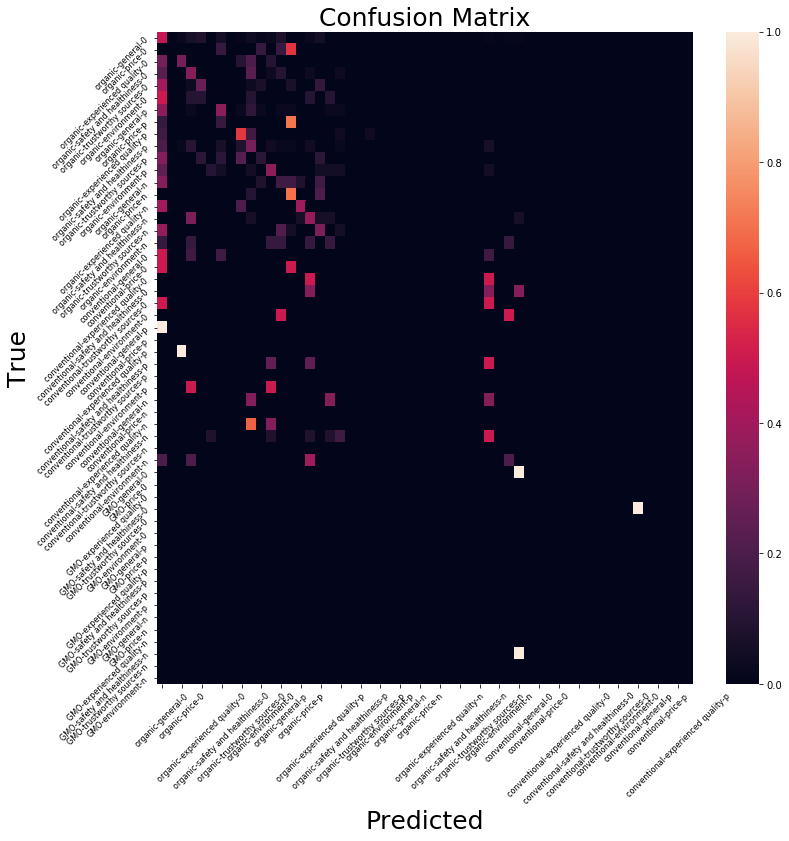

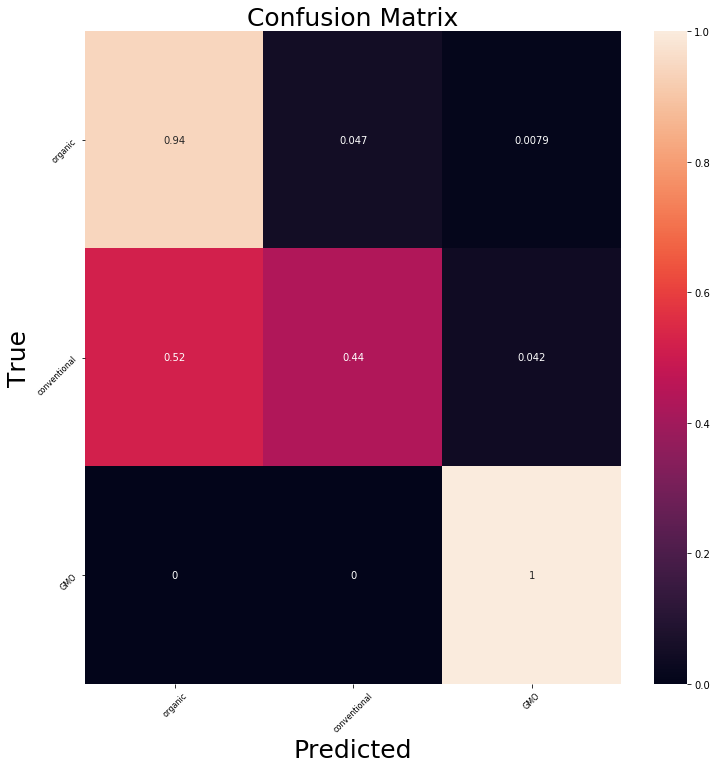

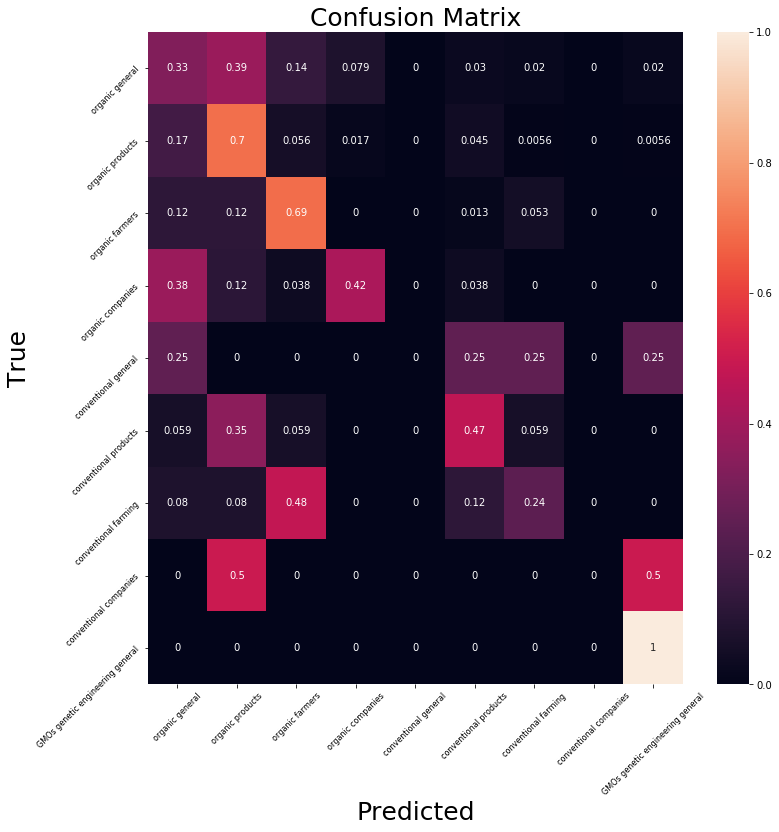

In [87]:
for head in headConfig:
    plot_Confusion_matrices(head)

In [0]:
get_cr_reports(shouldSave=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [0]:
produce_predictions(results, args.data_dir)